In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split

# Direct classes included for easyness
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model

In [2]:
# load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split, random_state=42)

### Enter your tag as unique id for saving

In [3]:
tag = str("quantumAutoencoder2-18032023")

In [4]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
x_qubits = 3
compression = 3

dev = qml.device("default.qubit", wires=(n_qubits+x_qubits))

Params in the quantum layer to train: 22
0: ──RY(0.07)──RY(0.69)─╭●──────────────────╭●──────────────────╭●─────────RY(0.84)──────────
1: ──RY(0.00)──RY(0.02)─╰RY(0.02)─╭●────────╰RY(0.54)─╭●────────╰RY(0.11)─╭●─────────RY(0.27)
2: ──RY(0.00)──RY(0.57)───────────╰RY(0.00)─╭●────────╰RY(0.87)─╭●────────╰RY(0.09)─╭●───────
3: ──RY(0.00)──RY(0.55)─────────────────────╰RY(0.90)─╭●────────╰RY(0.42)─╭●────────╰RY(0.68)
4: ──RY(0.00)──RY(0.86)───────────────────────────────╰RY(0.58)───────────╰RY(0.55)──────────
5: ──H───────────────────────────────────────────────────────────────────────────────────────
6: ──────────────────────────────────────────────────────────────────────────────────────────
7: ──────────────────────────────────────────────────────────────────────────────────────────

─────────────────────────────────────┤  <Z>
─────────────────────────────────────┤  <Z>
───RY(0.41)──────────────────────────┤  <Z>
──╭●─────────RY(0.97)───────╭SWAP────┤     
──╰RY(0.65)──RY(0.25)─╭SWAP─│─

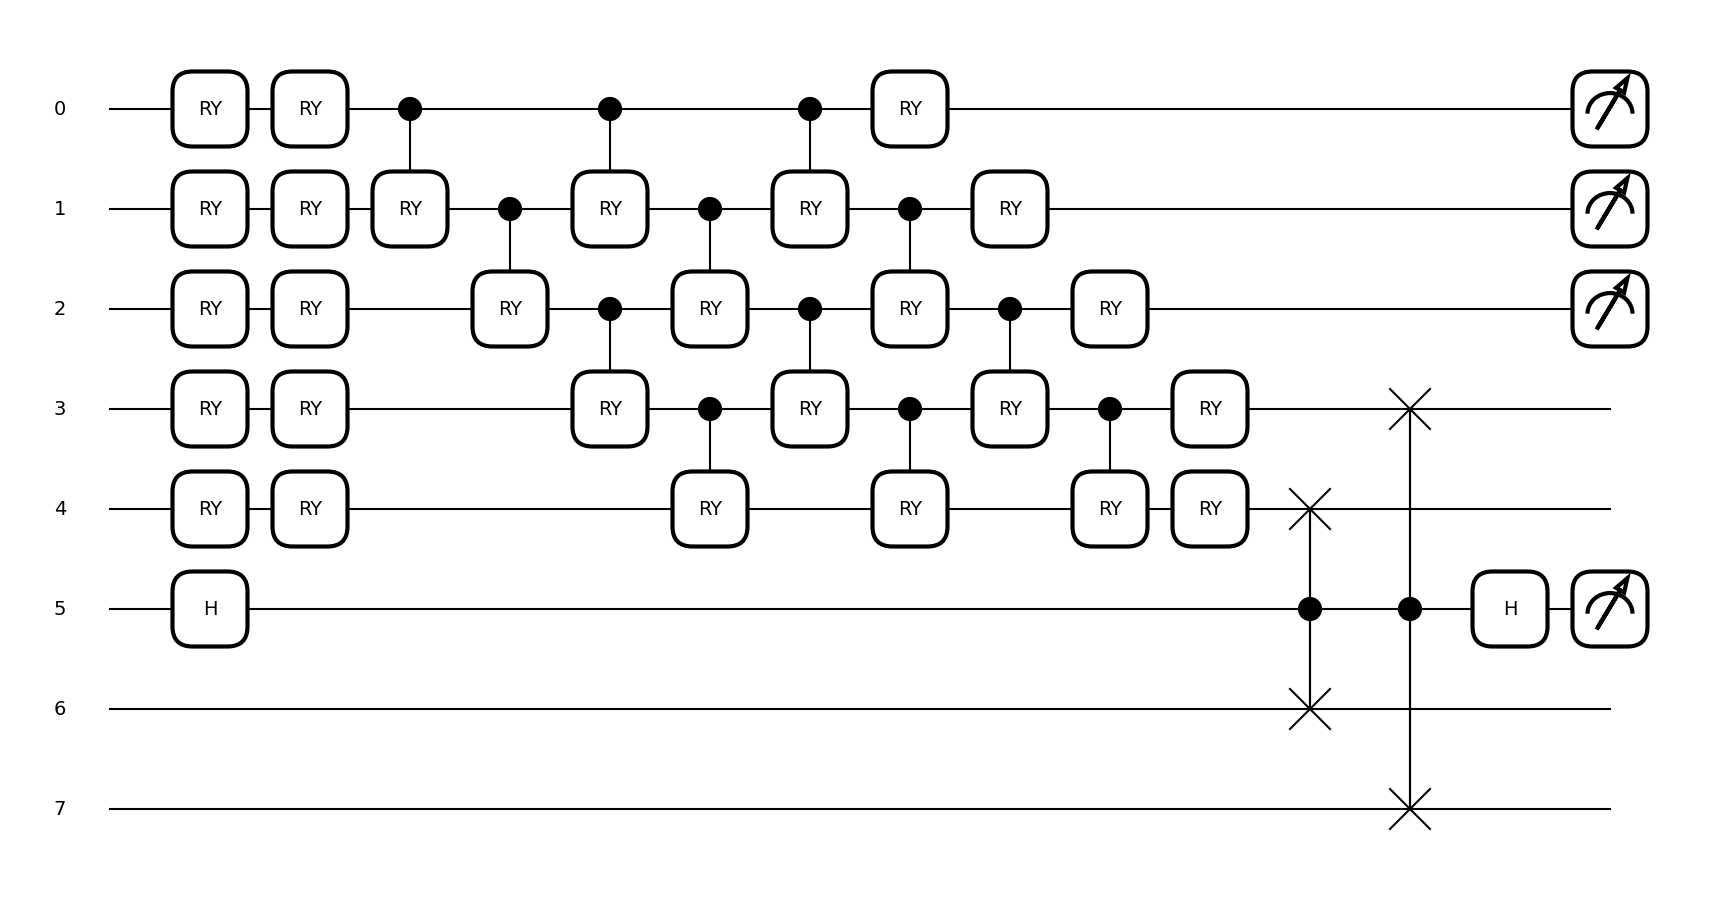

In [5]:
# Encoder
ENC_weight_shapes = {"weight1": (n_qubits),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1),
                 "weight5": (n_qubits)}
nE_qcParams = n_qubits*2+3*(n_qubits-1)
print(f"Params in the quantum layer to train: {nE_qcParams}")



@qml.qnode(dev)
def encoder(inputs, weight1, weight2, weight3, weight4, weight5):
    
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=inputs, pattern="single")
    
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight4, pattern="chain")
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    qml.Hadamard(wires=5)
    qml.CSWAP(wires=[5,6,4])
    qml.CSWAP(wires=[5,7,3])
    qml.Hadamard(wires=5)
    return [qml.expval(qml.PauliZ(wires=0)), qml.expval(qml.PauliZ(wires=1)), qml.expval(qml.PauliZ(wires=2)), qml.expval(qml.PauliZ(wires=5))]
    # return qml.expval(qml.PauliZ(wires=5))

qEncoder = qml.qnn.KerasLayer(encoder, ENC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(encoder)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits)))
fig1, ax = qml.draw_mpl(encoder)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits))
plt.show()
fig1.savefig("archive/Encoder-"+tag+".png")
fig1.savefig("archive/Encoder-"+tag+".pdf")

In [6]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']

inputLayer = Input(shape=(x_train.shape[1],))
encoded = qEncoder(inputLayer)
# Encoder
encoderModel = Model(inputLayer, encoded)
def cost(y_true, y_pred):
    y_pred = y_pred[:,3]
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)
def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

encoderModel.compile(optimizer = optRMS, loss=cost)

In [7]:
encoder_history = encoderModel.fit(x_train,np.ones((y_train.shape)), epochs=50, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping, LearningRateScheduler])

Epoch 1/50
31/31 [==============================] - 108s 4s/step - loss: 0.0043 - val_loss: 0.0086 - lr: 0.0500
Epoch 2/50
31/31 [==============================] - 101s 3s/step - loss: 0.0040 - val_loss: 0.0032 - lr: 0.0500
Epoch 3/50
31/31 [==============================] - 101s 3s/step - loss: 0.0039 - val_loss: 0.0069 - lr: 0.0500
Epoch 4/50
31/31 [==============================] - 100s 3s/step - loss: 0.0040 - val_loss: 0.0034 - lr: 0.0500
Epoch 5/50
31/31 [==============================] - 108s 4s/step - loss: 0.0038 - val_loss: 0.0032 - lr: 0.0500
Epoch 6/50
31/31 [==============================] - 108s 3s/step - loss: 0.0039 - val_loss: 0.0035 - lr: 0.0500
Epoch 7/50
31/31 [==============================] - 106s 3s/step - loss: 0.0038 - val_loss: 0.0049 - lr: 0.0500
Epoch 8/50
31/31 [==============================] - 107s 3s/step - loss: 0.0039 - val_loss: 0.0049 - lr: 0.0500
Epoch 9/50
31/31 [==============================] - 107s 3s/step - loss: 0.0037 - val_loss: 0.0036 - lr:

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 keras_layer (KerasLayer)    (None, 5)                 22        
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


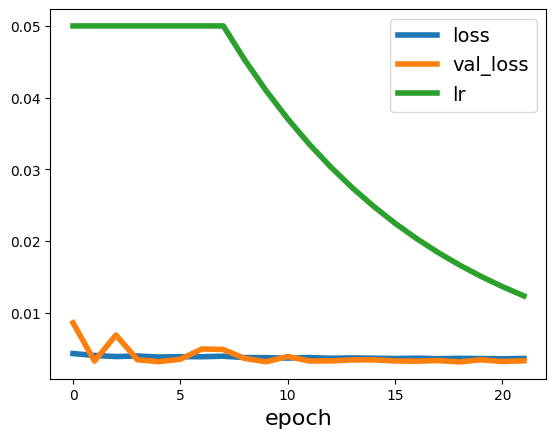

In [8]:
encoderModel.summary()
encoderModel.save("archive/encoderModelClean-"+tag+".h5")
encoderModel.save_weights("archive/encoderWeightsClean-"+tag+".h5")
config = encoderModel.get_config()
np.save("archive/encoderConfigClean-"+tag+".npy", config)
fig = plt.figure()
plt.plot(encoder_history.history['loss'], lw=4, label='loss')
plt.plot(encoder_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(encoder_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/historyENC-"+tag+".png")

In [9]:
encoded_train = encoderModel.predict(x_train)
encoded_train = encoded_train[:,:3]
np.save("ENCdata_"+tag+".npy", encoded_train)
print(encoded_train.shape)

32/32 [==============================] - 52s 2s/step
(1007, 3)


In [10]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
compression = 3

dev = qml.device("default.qubit", wires=n_qubits)

Params in the quantum layer to train: 22
0: ──RY(0.07)──RY(0.20)─╭●──────────────────╭●──────────────────╭●─────────RY(0.98)──────────
1: ──RY(0.00)──RY(0.09)─╰RY(0.99)─╭●────────╰RY(0.27)─╭●────────╰RY(0.66)─╭●─────────RY(0.80)
2: ──RY(0.00)──RY(0.15)───────────╰RY(0.45)─╭●────────╰RY(0.66)─╭●────────╰RY(0.18)─╭●───────
3: ──RY(0.35)───────────────────────────────╰RY(0.34)─╭●────────╰RY(0.36)─╭●────────╰RY(0.13)
4: ──RY(0.79)─────────────────────────────────────────╰RY(0.85)───────────╰RY(0.73)──────────

──────────────────────┤  <Z>
──────────────────────┤  <Z>
───RY(0.06)───────────┤  <Z>
──╭●─────────RY(0.22)─┤  <Z>
──╰RY(0.23)──RY(0.27)─┤  <Z>


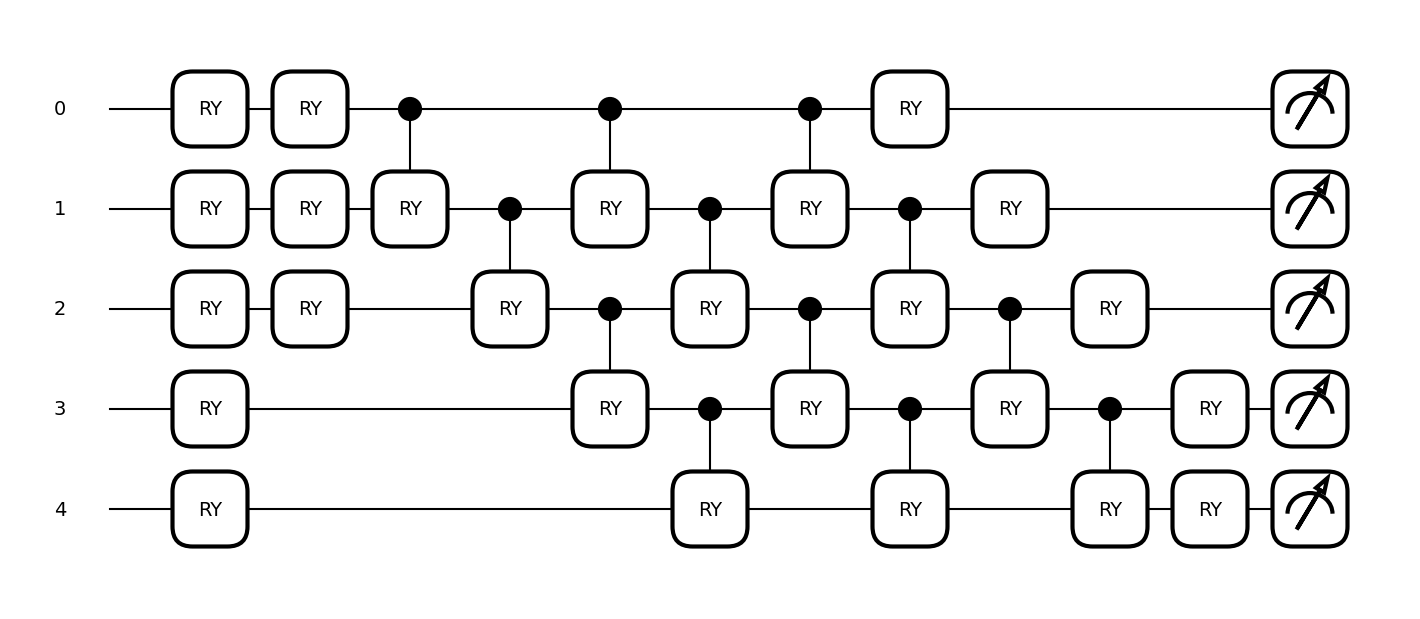

In [11]:

# Decoder
DEC_weight_shapes = {"weight1": (n_qubits),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1),
                 "weight5": (n_qubits)}
nD_qcParams = n_qubits*2+3*(n_qubits-1)
print(f"Params in the quantum layer to train: {nD_qcParams}")



@qml.qnode(dev)
def decoder(inputs, weight1, weight2, weight3, weight4, weight5):
    qml.broadcast(qml.RY, wires=range(compression), parameters=inputs, pattern="single")
    
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight4, pattern="chain")
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qDecoder = qml.qnn.KerasLayer(decoder, DEC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(decoder)(x_train[0,:3],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits)))
fig2, ax = qml.draw_mpl(decoder)(x_train[0,:3],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits))
plt.show()
fig2.savefig("archive/Decoder-"+tag+".png")
fig2.savefig("archive/Decoder-"+tag+".pdf")

In [12]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']

inputLayer = Input(shape=(encoded_train.shape[1],))
decoded = qDecoder(inputLayer)
# Decoder
decoderModel = Model(inputLayer, decoded)
def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

decoderModel.compile(optimizer = optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

In [13]:
print(encoded_train.shape)

(1007, 3)


In [14]:
decoder_history = decoderModel.fit(encoded_train, x_train, epochs=50, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping, LearningRateScheduler])

Epoch 1/50
31/31 [==============================] - 91s 3s/step - loss: 0.0928 - mean_absolute_error: 0.2439 - val_loss: 0.0830 - val_mean_absolute_error: 0.2250 - lr: 0.0500
Epoch 2/50
31/31 [==============================] - 91s 3s/step - loss: 0.0730 - mean_absolute_error: 0.2136 - val_loss: 0.0852 - val_mean_absolute_error: 0.2137 - lr: 0.0500
Epoch 3/50
31/31 [==============================] - 91s 3s/step - loss: 0.0717 - mean_absolute_error: 0.2098 - val_loss: 0.0664 - val_mean_absolute_error: 0.1928 - lr: 0.0500
Epoch 4/50
31/31 [==============================] - 91s 3s/step - loss: 0.0701 - mean_absolute_error: 0.2068 - val_loss: 0.0847 - val_mean_absolute_error: 0.2158 - lr: 0.0500
Epoch 5/50
31/31 [==============================] - 92s 3s/step - loss: 0.0706 - mean_absolute_error: 0.2071 - val_loss: 0.0735 - val_mean_absolute_error: 0.2115 - lr: 0.0500
Epoch 6/50
31/31 [==============================] - 91s 3s/step - loss: 0.0703 - mean_absolute_error: 0.2063 - val_loss: 0.07

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 5)                 22        
                                                                 
Total params: 22
Trainable params: 22
Non-trainable params: 0
_________________________________________________________________


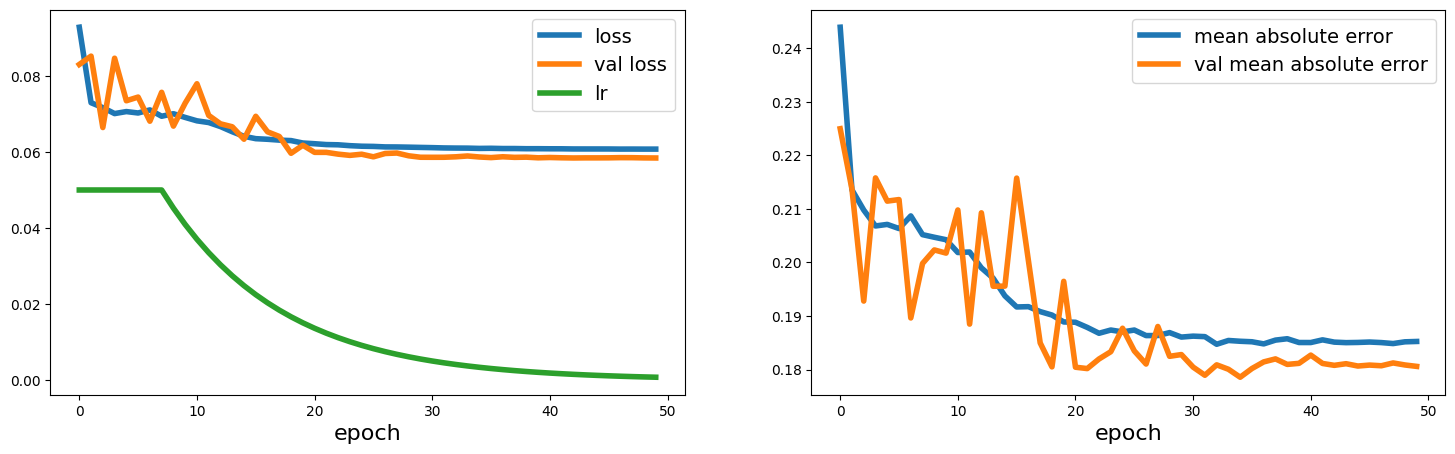

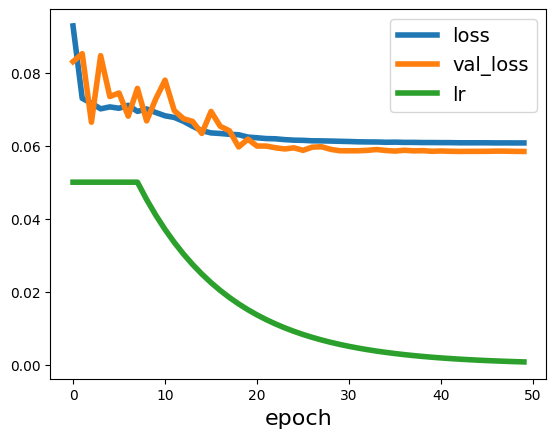

In [15]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(decoder_history)
decoderModel.summary()

fig = plt.figure()
plt.plot(decoder_history.history['loss'], lw=4, label='loss')
plt.plot(decoder_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(decoder_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/historyDEC-"+tag+".png")

In [16]:
#Create a autoencode like in https://blog.keras.io/building-autoencoders-in-keras.html
clear_session()

inputLayer = Input(shape=(x_train.shape[1],))
encoded = encoderModel(inputLayer)
encoded = encoded[:,:3]
decoded = decoderModel(encoded)
autoencoder = Model(inputLayer, decoded)
print(f"Params in all quantum layers to train: {nD_qcParams+nE_qcParams}")
autoencoder.summary()

Params in all quantum layers to train: 44
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 model (Functional)          (None, 5)                 22        
                                                                 
 tf.__operators__.getitem (S  (None, 3)                0         
 licingOpLambda)                                                 
                                                                 
 model_1 (Functional)        (None, 5)                 22        
                                                                 
Total params: 44
Trainable params: 44
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

autoencoder.compile(optimizer = optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

autoencoder_history = autoencoder.fit(x_train[:334,:], x_train[:334,:], epochs=25, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping, LearningRateScheduler])

Epoch 1/25
10/10 [==============================] - 115s 12s/step - loss: 0.0675 - mean_absolute_error: 0.1920 - val_loss: 0.0490 - val_mean_absolute_error: 0.1574 - lr: 0.0500
Epoch 2/25
10/10 [==============================] - 115s 12s/step - loss: 0.0527 - mean_absolute_error: 0.1745 - val_loss: 0.0474 - val_mean_absolute_error: 0.1574 - lr: 0.0500
Epoch 3/25
10/10 [==============================] - 115s 12s/step - loss: 0.0515 - mean_absolute_error: 0.1683 - val_loss: 0.0515 - val_mean_absolute_error: 0.1772 - lr: 0.0500
Epoch 4/25
10/10 [==============================] - 115s 12s/step - loss: 0.0464 - mean_absolute_error: 0.1523 - val_loss: 0.0571 - val_mean_absolute_error: 0.1835 - lr: 0.0500
Epoch 5/25
10/10 [==============================] - 115s 12s/step - loss: 0.0503 - mean_absolute_error: 0.1669 - val_loss: 0.0466 - val_mean_absolute_error: 0.1523 - lr: 0.0500
Epoch 6/25
10/10 [==============================] - 115s 12s/step - loss: 0.0475 - mean_absolute_error: 0.1589 - va

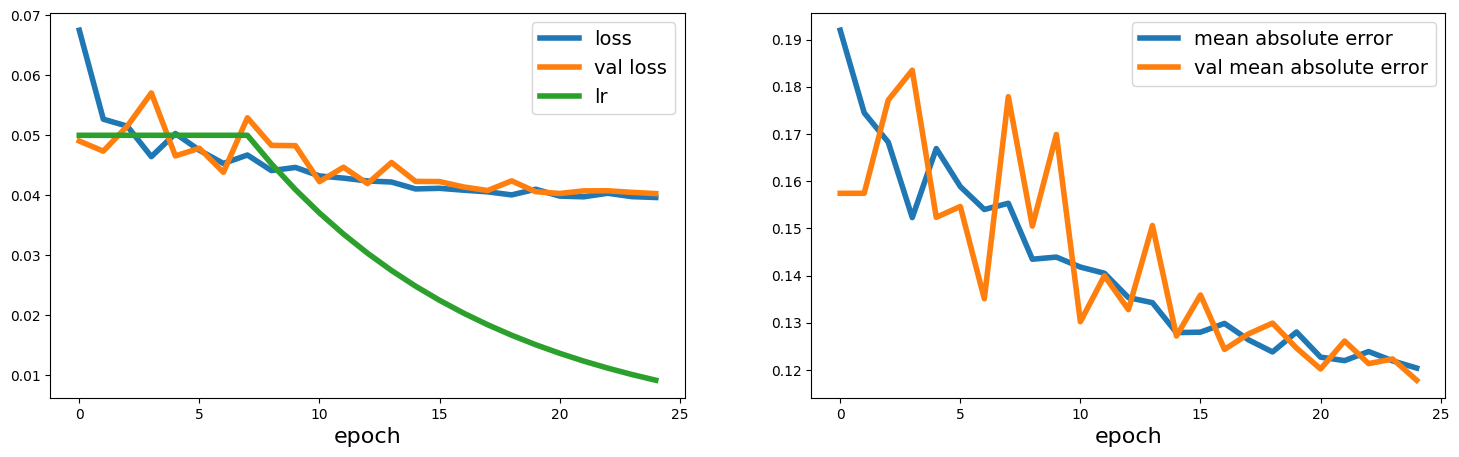

In [18]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(autoencoder_history)

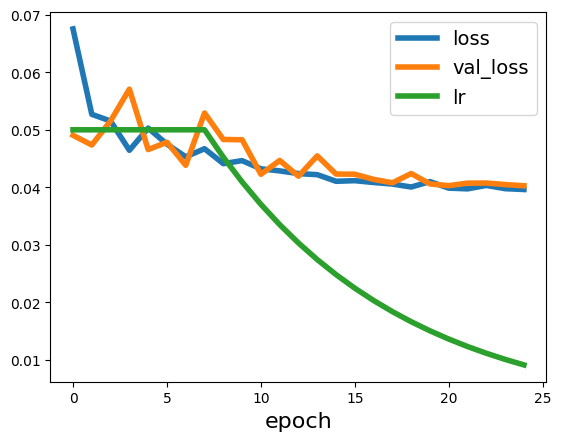

In [19]:
fig = plt.figure()
plt.plot(autoencoder_history.history['loss'], lw=4, label='loss')
plt.plot(autoencoder_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(autoencoder_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [20]:
evaluation = autoencoder.evaluate(x_test[:-1], x_test[:-1])
encoded_test = encoderModel.predict(x_test)
decoded_test = decoderModel.predict(encoded_test[:,:3])
print(f'Data: {x_test[0,:]} to be: {encoded_test[0,:]} and rebuilded it to: {decoded_test[0,:]}')

16/16 [==============================] - 41s 3s/step
Data: [0.03030303 1.         0.         1.         0.36229778] to be: [0.58427295 0.69718065 0.57679039 0.93448362] and rebuilded it to: [ 0.0366825   0.80108017 -0.01457309  0.58524301  0.28747661]


In [21]:
encoderModel.save("archive/encoderModel-"+tag+".h5")
encoderModel.save_weights("archive/encoderWeights-"+tag+".h5")
decoderModel.save("archive/encoderModel-"+tag+".h5")
decoderModel.save_weights("archive/decoderWeights-"+tag+".h5")
autoencoder.save("archive/completeModel-"+tag+".h5")
autoencoder.save_weights("archive/autoencoderWeights-"+tag+".h5")
config = encoderModel.get_config()
np.save("archive/encoderConfig-"+tag+".npy", config)
config = decoderModel.get_config()
np.save("archive/decoderConfig-"+tag+".npy", config)
config = autoencoder.get_config()
np.save("archive/completeConfig-"+tag+".npy", config)